# Segment images with GrabCut Algorithm

In [1]:
# Python 3.8.8
import matplotlib.pyplot as plt # version 3.4.2
import numpy as np # version 1.19.5
import cv2 # version 4.5.2.54
import datetime
import glob
import os

In [2]:
# A class that tracks the current index of image that is being processed
# NOTE: Counter starts from 0 and continues until "total num of images - 1"
class Counter:
    def __init__(self, max_value):
        self.value = 0
        self.max_value = max_value
    
    # Increase the counter value by one everytime this is run, unless reached the maximum number
    def counting(self):
        if self.value < (self.max_value-1):
            self.value += 1
            return True
        else:
            print("The maximum number has been reached")
            return False
            
    
    # Reset the counter
    def reset(self):
        self.value = 0 
    
    # A function to set the counter to a specific number
    def set_manually(self, set_value):
        self.value = set_value
        

# Change the "ALPHABET" variables whenver switching alphabet, otherwise don't have to modify this section

In [536]:
# Define the specific directory to input the images and output the cropped images
ALPHABET = 'z' # a, b, c, d,......, z
INPUT_DIR = 'Image/CollectedImage/Phone_0507/alphabet_{}/*.jp*g'.format(ALPHABET)
OUTPUT_DIR = 'Image/CollectedImage/Hand_Image_Cropped/alphabet_{}'.format(ALPHABET)

# Define a list containing the path of all the images corresponds to a specific alphabet
input_image_list = glob.glob(INPUT_DIR)
len(input_image_list) # Number of images for the specific letter

29

In [537]:
# Define the class
counter = Counter(max_value=len(input_image_list))

### 1) Load the image

# Repeat the process from here onwards when moving on to the next image of the same alphabet

In [1051]:
# Double check the value to make sure it's right""""""
#counter.set_manually(1)
counter.value

28

In [1052]:
# Load the specific image
img_ori = cv2.imread(input_image_list[counter.value])
# Resize the image into desired size, ensuring its no bigger than the laptop screen size
img_resize = cv2.resize(src=img_ori, dsize=(640,480))

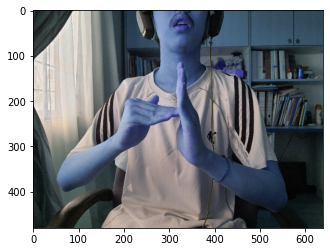

In [1053]:
plt.imshow(img_resize)

### 2) Draw a bounding box as an input for the GrabCut algorithm

A bounding box is used to label the nodes as foreground or background. Every nodes within the bounding box are denoted as foreground, vice versa

- replace "img" with "img_resize" if were to draw the bounding box on the original image

In [1054]:
# Define the img variable whether it will be original, img_ori or the resized image, img_resize
img = img_resize

In [1055]:
# A function that draws a rectangle on an image

def draw_rec(event, x, y, flags, param):
    # Set the variables as global so that they are not bounded by the events, they are continuous
    global ix, iy, ix2, iy2
    
    # When mouse left button is clicked
    if event == cv2.EVENT_LBUTTONDOWN:
        # Define the first coordinate of the rectangle (upper left corner)
        # x and changes according to the cursor position within the OpenCV windows
        ix, iy = x, y
    
    # When mouse left button is unclicked
    elif event == cv2.EVENT_LBUTTONUP:
        # Define the second coordinate of the rectangle (lower right corner)
        ix2, iy2 = x, y
        # Draw on the image copy instead of the original image incase we have to revert back to the original one
        cv2.rectangle(img_copy, (ix, iy), (ix2, iy2), (0,255,0), 2)
        
# Define a opencv window for displaying the image and interacting with it
cv2.namedWindow('Image to draw rectangle on')
# Bind the mouse callback function to the OpenCV window
cv2.setMouseCallback('Image to draw rectangle on', draw_rec)

# Make a copy of the original image so that we can revert back to the original one if we want to
img_copy = img.copy()

while True:
    cv2.imshow('Image to draw rectangle on', img_copy)
    
    k = cv2.waitKey(1) & 0xFF
    # When 'z' key is pressed
    if k == ord('z'):
        img_copy = img.copy() # Make a copy of the original image again, this undo all the changes made to the image
        
    # When 'q' key is pressed
    elif k == ord('q'):
        break # Stop the loop
    
# Destroy all of the OpenCV windows
cv2.destroyAllWindows()    

In [1056]:
# The coordinates of the bounding box
ix, iy, ix2, iy2

(161, 89, 423, 372)

### 3) Initialise the GrabCut algorithm with the bounding box drawn

**NOTE:**
-   BACKGROUND: cv2.GC_BGD = 0
-   FOREGROUND: cv2.GC_FGD = 1
-   PROPABLE BACKGROUND: cv2.GC_PR_BGD = 2
-   PROPABLE FOREGROUND: cv2.GC_PR_FGD = 3

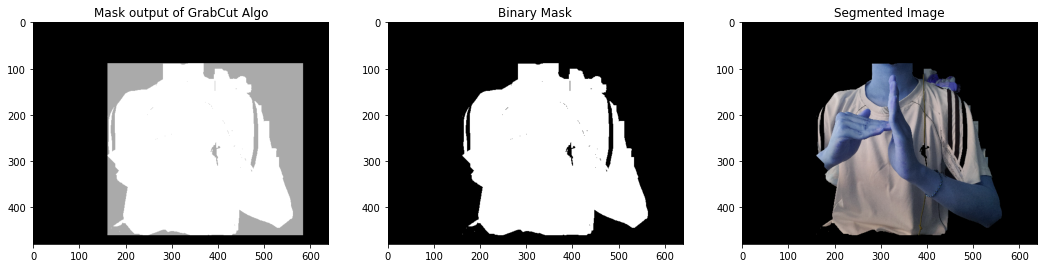

In [1057]:
# Create a mask of same size as the image
mask = np.zeros(img.shape[:2])

# Define the array that will be used as the internal memory for the GrabCut algorithm
bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

# Segment the image using GrabCut algorithm
output_mask, bgdModel, fgdModel = cv2.grabCut(img=img, mask=mask, rect=(ix,iy,ix2,iy2), bgdModel=bgdModel, fgdModel=fgdModel, iterCount=5, mode=cv2.GC_INIT_WITH_RECT )
plt.figure(figsize=(18,15))
plt.subplot(131)
plt.title("Mask output of GrabCut Algo")
plt.imshow(output_mask, cmap='gray')

# If the mask value is 0, BACKGROUND or 2, PROPABLE BACKGROUND, convert the value to 0, BACKGROUND, otherwise, convert to 1, FOREGROUND
binary_mask = np.where( (output_mask==0) | (output_mask==2), 0, 1)
plt.subplot(132)
plt.title("Binary Mask")
plt.imshow(binary_mask, cmap='gray')

segmented_img = binary_mask[:,:,np.newaxis] * img
plt.subplot(133)
plt.title("Segmented Image")
plt.imshow(segmented_img)

In [1058]:
# # Filter and visualise each mapping of the mask output, where white colour in the image indicates the output
# plt.figure(figsize=(20,15))

# plt.subplot(141)
# visualise_mask_output = (output_mask == 0) # Background
# plt.title("Background")
# plt.imshow(visualise_mask_output, cmap='gray')

# plt.subplot(142)
# visualise_mask_output = (output_mask == 1) # Foreground
# plt.title("Foreground")
# plt.imshow(visualise_mask_output, cmap='gray')

# plt.subplot(143)
# visualise_mask_output = (output_mask == 2) # Propable Background
# plt.title("Propable Background")
# plt.imshow(visualise_mask_output, cmap='gray')

# plt.subplot(144)
# visualise_mask_output = (output_mask == 3) # Propable Foreground
# plt.title("Propable Foreground")
# plt.imshow(visualise_mask_output, cmap='gray')

### 4) Draw a custom mask on the image to further indicate whether the uncertain pixels belong to foreground or background
- The output mask from the GrabCut (initialised by the bounding box) most likely will not be perfect, a few touch ups might be needed to produce the final output mask

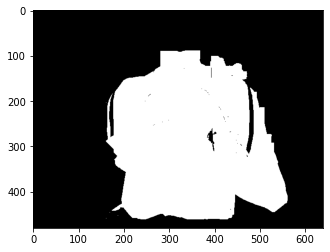

In [1059]:
# Modify the binary mask from upper section to convert "foreground" to "propable background"
# NOTE: "propable background" of the output mask has been converted to "background", in "binary_mask"
# whereas "propable foreground" of the output mask has been converted to "foreground", in "binary_mask"
# Equivalent of mask2 = np.where((binary_mask==1), 2, 0)
mask2 = np.where((binary_mask==cv2.GC_FGD), cv2.GC_PR_BGD, cv2.GC_BGD) #  mask2 contains only "propable background" and "background"
plt.imshow(mask2, cmap='gray')

In [1060]:
# Set the drawing flag to False until we actually start drawing (when mouse left button is clicked and holded)
# This flag will decide whether we can draw on the image or not
draw = False
# Set the default mode for drawing, which is background, gives grey coloured line
mode = 'background'
# Set the default radius for drawing lines
draw_radius = 3


# Define the mouse callback function to bind with the opencv windows later on
def draw_line(event, x, y, flags, param):
    # Set the variables to be global so that they are continuous
    global draw, mode
    
    # When mouse left button is clicked, set drawing flag as True
    if event == cv2.EVENT_LBUTTONDOWN:
        draw = True
        # Draw lines of white colour to indicate foreground
        if mode == 'foreground':
            cv2.circle(img=segmented_img_copy, center=(x,y), radius=draw_radius, color=(255,255,255), thickness=-1)
            cv2.circle(img=mask2_copy, center=(x,y), radius=draw_radius, color=(255), thickness=-1)
              
        # Draw lines of grey colour to indicate background
        elif mode == 'background':
            cv2.circle(img=segmented_img_copy, center=(x,y), radius=draw_radius, color=(125,125,125), thickness=-1)
            cv2.circle(img=mask2_copy, center=(x,y), radius=draw_radius, color=(125), thickness=-1)
    
    # When mouse cursor moves, starts drawing only when drawing flag is being set to True
    if event == cv2.EVENT_MOUSEMOVE:
        if draw == True:
            # Draw lines of white colour to indicate foreground
            if mode == 'foreground':
                cv2.circle(img=segmented_img_copy, center=(x,y), radius=draw_radius, color=(255,255,255), thickness=-1)
                cv2.circle(img=mask2_copy, center=(x,y), radius=draw_radius, color=(255), thickness=-1)
              
            # Draw lines of grey colour to indicate background
            elif mode == 'background':
                cv2.circle(img=segmented_img_copy, center=(x,y), radius=draw_radius, color=(125,125,125), thickness=-1)
                cv2.circle(img=mask2_copy, center=(x,y), radius=draw_radius, color=(125), thickness=-1)
                   
    # When mouose right button is unclicked, set drawing flag as False
    elif event == cv2.EVENT_LBUTTONUP:
        draw = False
    
segmented_img_copy = segmented_img.astype(np.uint8).copy() # Must be 8 bits integer (range of value from 0-255)
mask2_copy = mask2.astype(np.uint8).copy() # Must be 8 bits integer (range of value from 0-255)

# Create an opencv window
cv2.namedWindow('Segmented Image')
# Bind the mouse callback function to the opencv window
cv2.setMouseCallback('Segmented Image', draw_line)


while True:
    cv2.imshow('Display Drawn Mask', mask2_copy)
    cv2.imshow('Segmented Image', segmented_img_copy)
    
    k = cv2.waitKey(1) & 0xFF
    # Stop the loop and close the window when 'q' key is pressed
    if k == ord('q'):
        break
    # Revert all drawing made to the image when 'z' key is pressed
    elif k == ord('z'):
        mask2_copy = mask2.astype(np.uint8).copy()
        segmented_img_copy = segmented_img.astype(np.uint8).copy()
    # Change to background mode (produces grey line) when 'd' key is pressed
    elif k == ord('d'):
        mode = 'background'
    # Change to foregorund mode (produces white line) when 'e' key is pressed
    elif k == ord('e'):
        mode = 'foreground'
    # Increase the circle radius for drawing by 1 when 'w' key is pressed
    elif k == ord('w'):
        # Only increase until the maximum radius of 10
        if draw_radius < 10:
            draw_radius += 1
    # Decrease the circle radius for drawing by 1 when 's' key is pressed
    elif k == ord('s'):
        # Only decrease until the minimum radius of 1
        if draw_radius > 1:
            draw_radius -= 1
    
# Destroy all the OpenCV windows
cv2.destroyAllWindows()

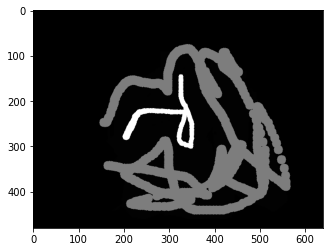

In [1061]:
# Display the drawn mask
plt.imshow(mask2_copy, cmap='gray')

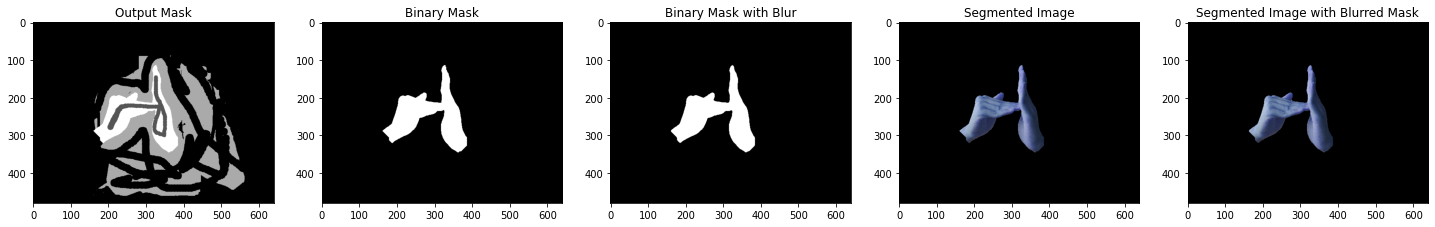

In [1062]:
# An intermediate step of using different value, e.g. 125 and 255, is for visualisation purposes in the drawing process
mask2_copy[mask2_copy==125] = cv2.GC_BGD # Equivalent to 0
mask2_copy[mask2_copy==255] = cv2.GC_FGD # Equivalent to 1

# Further segment the segmented image again, initialised by the provided mask (in our case, the post-processed "mask2_copy")
output_mask2, bgdModel, fgdModel = cv2.grabCut(img=segmented_img.astype(np.uint8), mask=mask2_copy.astype(np.uint8), rect=None, bgdModel=bgdModel, fgdModel=fgdModel, iterCount=5, mode=cv2.GC_INIT_WITH_MASK )

plt.figure(figsize=(25,20))
plt.subplot(151)
plt.title("Output Mask")
plt.imshow(output_mask2, cmap='gray')

# Convert all the "foreground", 1 and "propable foreground", 3 to 1
# Convert all the "background", 0 and "propable background", 2 to 0
binary_mask2 = np.where( (output_mask2==0) | (output_mask2==2), 0, 1)
binary_mask2_blur = cv2.medianBlur(binary_mask2.astype(np.uint8), 5)

plt.subplot(152)
plt.title("Binary Mask")
plt.imshow(binary_mask2, cmap='gray')

plt.subplot(153)
plt.title("Binary Mask with Blur")
plt.imshow(binary_mask2_blur, cmap='gray')

# Segment the image using the binary mask (post-processed mask)
segmented_img2 = binary_mask2[:,:,np.newaxis] * segmented_img
plt.subplot(154)
plt.title("Segmented Image")
plt.imshow(segmented_img2)

# Segment the image using the binary mask (post-processed mask)
segmented_img2_blur = binary_mask2_blur[:,:,np.newaxis] * segmented_img
plt.subplot(155)
plt.title("Segmented Image with Blurred Mask")
plt.imshow(segmented_img2_blur)

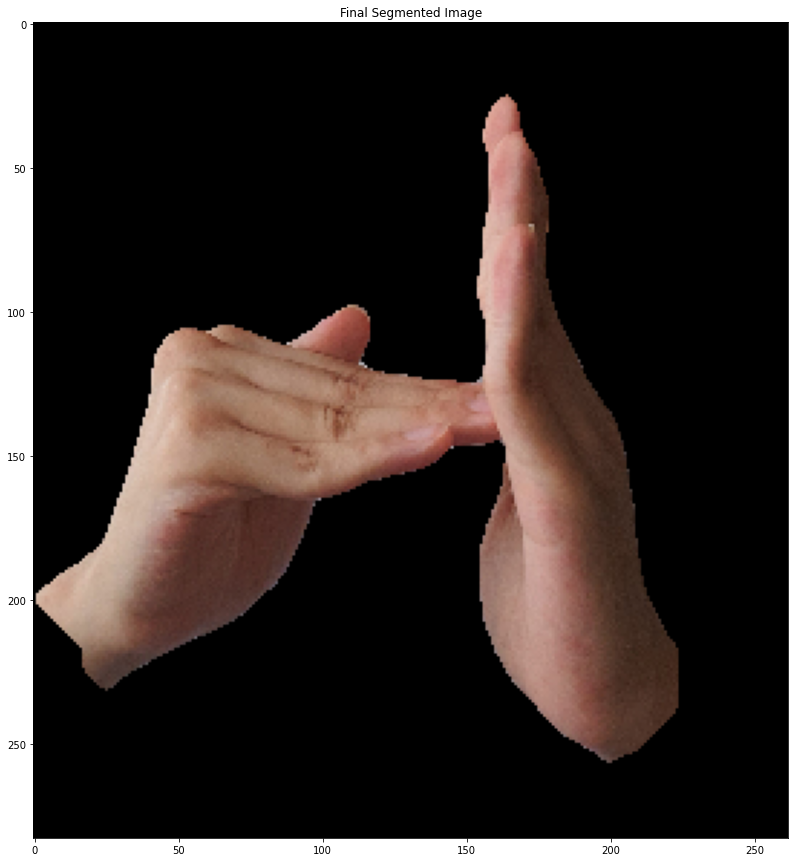

In [1063]:
plt.figure(figsize=(15,15))
plt.title("Final Segmented Image")
plt.imshow(cv2.cvtColor(segmented_img2_blur[iy:iy2, ix:ix2, :].astype(np.uint8), cv2.COLOR_BGR2RGB))

### 5) Save the image if satisfied, otherwise, continue with the segmentation

In [1064]:
# Save the image and increase the counter when the result is satisfied
response = input('Satisfied?') # response is either 'q' or 'z'

# If satisfied, equivalent to 'q'
if (response == 'q' or response == 'y'):
    # Save the image into the specific directory
    output_img_path = os.path.join(OUTPUT_DIR, 'cropped_{}_{:03}.png'.format(ALPHABET, counter.value))
    cv2.imwrite(output_img_path, segmented_img2_blur[iy:iy2, ix:ix2, :])
    
    # Increase the counter by one if allowed (not equal or greater than the maximum limit)
    continue_ = counter.counting()
    if continue_:
        print("The counter has increased by 1, which is: {}".format(counter.value))
        print("Repeat the process for the next image")
    else:
        print("There's no more images left for this alphabet")
        
    
# If not satisfied, equivalent to 'z'
elif (response == 'z' or response == 'n'):
    print("Restart the GrabCut algorithm from any desired checkpoint")

# Stop the cell command when 'b' is given
elif response == 'b':
    pass

Satisfied? y


The maximum number has been reached
There's no more images left for this alphabet


In [1065]:
#counter.set_manually(25)
counter.value

28

### 6) Repeat the touch up process when not satisfied

In [1008]:
# Modify the binary mask from upper section to convert "foreground" to "propable background"
# NOTE: "propable background" of the output mask has been converted to "background", in "binary_mask"
# whereas "propable foreground" of the output mask has been converted to "foreground", in "binary_mask"
# Equivalent of mask2 = np.where((binary_mask==1), 2, 0)
mask3 = np.where((binary_mask2_blur==cv2.GC_FGD), cv2.GC_PR_BGD, cv2.GC_BGD) #  mask2 contains only "propable background" and "background"

# Set the drawing flag to False until we actually start drawing (when mouse left button is clicked and holded)
# This flag will decide whether we can draw on the image or not
draw = False
# Set the default mode for drawing, which is background, gives grey coloured line
mode = 'background'
# Set the default radius for drawing lines
draw_radius = 3


# Define the mouse callback function to bind with the opencv windows later on
def draw_line(event, x, y, flags, param):
    # Set the variables to be global so that they are continuous
    global draw, mode
    
    # When mouse left button is clicked, set drawing flag as True
    if event == cv2.EVENT_LBUTTONDOWN:
        draw = True
        # Draw lines of white colour to indicate foreground
        if mode == 'foreground':
            cv2.circle(img=segmented_img2_copy, center=(x,y), radius=draw_radius, color=(255,255,255), thickness=-1)
            cv2.circle(img=mask3_copy, center=(x,y), radius=draw_radius, color=(255), thickness=-1)
              
        # Draw lines of grey colour to indicate background
        elif mode == 'background':
            cv2.circle(img=segmented_img2_copy, center=(x,y), radius=draw_radius, color=(125,125,125), thickness=-1)
            cv2.circle(img=mask3_copy, center=(x,y), radius=draw_radius, color=(125), thickness=-1)
    
    # When mouse cursor moves, starts drawing only when drawing flag is being set to True
    if event == cv2.EVENT_MOUSEMOVE:
        if draw == True:
            # Draw lines of white colour to indicate foreground
            if mode == 'foreground':
                cv2.circle(img=segmented_img2_copy, center=(x,y), radius=draw_radius, color=(255,255,255), thickness=-1)
                cv2.circle(img=mask3_copy, center=(x,y), radius=draw_radius, color=(255), thickness=-1)
              
            # Draw lines of grey colour to indicate background
            elif mode == 'background':
                cv2.circle(img=segmented_img2_copy, center=(x,y), radius=draw_radius, color=(125,125,125), thickness=-1)
                cv2.circle(img=mask3_copy, center=(x,y), radius=draw_radius, color=(125), thickness=-1)
                   
    # When mouose right button is unclicked, set drawing flag as False
    elif event == cv2.EVENT_LBUTTONUP:
        draw = False
    
segmented_img2_copy = segmented_img2_blur.astype(np.uint8).copy() # Must be 8 bits integer (range of value from 0-255)
mask3_copy = mask3.astype(np.uint8).copy() # Must be 8 bits integer (range of value from 0-255)

# Create an opencv window
cv2.namedWindow('Segmented Image')
# Bind the mouse callback function to the opencv window
cv2.setMouseCallback('Segmented Image', draw_line)


while True:
    cv2.imshow('Display Drawn Mask', mask3_copy)
    cv2.imshow('Segmented Image', segmented_img2_copy)
    
    k = cv2.waitKey(1) & 0xFF
    # Stop the loop and close the window when 'q' key is pressed
    if k == ord('q'):
        break
    # Revert all drawing made to the image when 'z' key is pressed
    elif k == ord('z'):
        mask3_copy = mask3.astype(np.uint8).copy()
        segmented_img2_copy = segmented_img2_blur.astype(np.uint8).copy()
    # Change to background mode (produces grey line) when 'd' key is pressed
    elif k == ord('d'):
        mode = 'background'
    # Change to foregorund mode (produces white line) when 'e' key is pressed
    elif k == ord('e'):
        mode = 'foreground'
    # Increase the circle radius for drawing by 1 when 'w' key is pressed
    elif k == ord('w'):
        # Only increase until the maximum radius of 10
        if draw_radius < 10:
            draw_radius += 1
    # Decrease the circle radius for drawing by 1 when 's' key is pressed
    elif k == ord('s'):
        # Only decrease until the minimum radius of 1
        if draw_radius > 1:
            draw_radius -= 1
    
# Destroy all the OpenCV windows
cv2.destroyAllWindows()


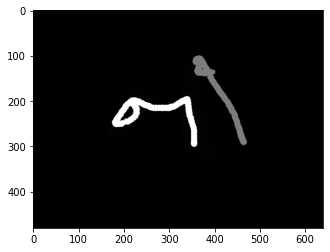

In [1009]:
# Display the drawn mask
plt.imshow(mask3_copy, cmap='gray')

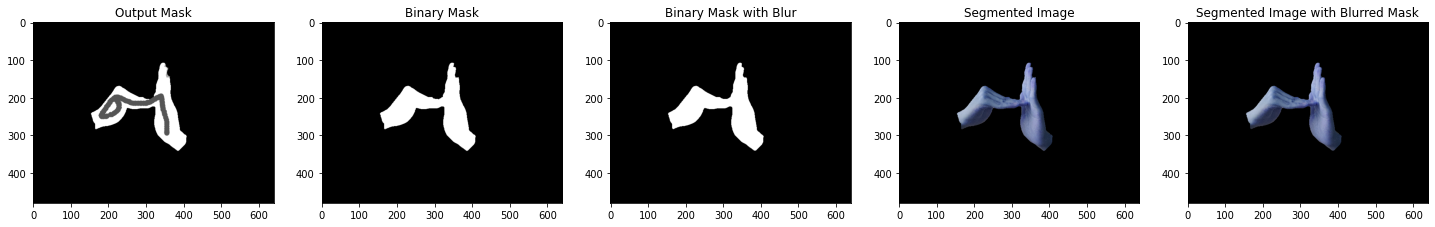

In [1010]:
# An intermediate step of using different value, e.g. 125 and 255, is for visualisation purposes in the drawing process
mask3_copy[mask3_copy==125] = cv2.GC_BGD # Equivalent to 0
mask3_copy[mask3_copy==255] = cv2.GC_FGD # Equivalent to 1

# Further segment the segmented image again, initialised by the provided mask (in our case, the post-processed "mask2_copy")
output_mask3, bgdModel, fgdModel = cv2.grabCut(img=segmented_img2_blur.astype(np.uint8), mask=mask3_copy.astype(np.uint8), rect=None, bgdModel=bgdModel, fgdModel=fgdModel, iterCount=5, mode=cv2.GC_INIT_WITH_MASK )

plt.figure(figsize=(25,20))
plt.subplot(151)
plt.title("Output Mask")
plt.imshow(output_mask3, cmap='gray')

# Convert all the "foreground", 1 and "propable foreground", 3 to 1
# Convert all the "background", 0 and "propable background", 2 to 0
binary_mask3 = np.where( (output_mask3==0) | (output_mask3==2), 0, 1)
binary_mask3_blur = cv2.medianBlur(binary_mask3.astype(np.uint8), 5)

plt.subplot(152)
plt.title("Binary Mask")
plt.imshow(binary_mask3, cmap='gray')

plt.subplot(153)
plt.title("Binary Mask with Blur")
plt.imshow(binary_mask3_blur, cmap='gray')

# Segment the image using the binary mask (post-processed mask)
segmented_img3 = binary_mask3[:,:,np.newaxis] * segmented_img2_blur
plt.subplot(154)
plt.title("Segmented Image")
plt.imshow(segmented_img3)

# Segment the image using the binary mask (post-processed mask)
segmented_img3_blur = binary_mask3_blur[:,:,np.newaxis] * segmented_img2_blur
plt.subplot(155)
plt.title("Segmented Image with Blurred Mask")
plt.imshow(segmented_img3_blur)

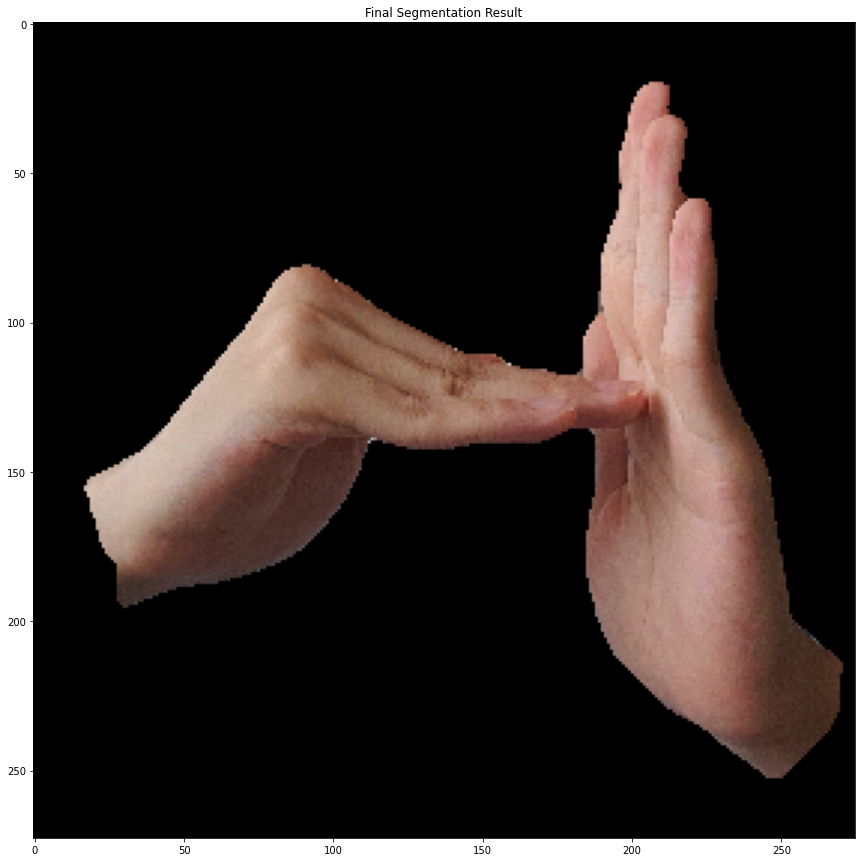

In [1011]:
plt.figure(figsize=(15,15))
plt.title("Final Segmentation Result")
plt.imshow(cv2.cvtColor(segmented_img3_blur[iy:iy2, ix:ix2,:].astype(np.uint8), cv2.COLOR_BGR2RGB))

In [1012]:
### 7) Save the masked image in the desired directory when satisfied

In [1013]:
# Save the image and increase the counter when the result is satisfied
response = input('Satisfied?') # response is either 'q' or 'z'

# If satisfied, equivalent to 'q' or 'y'
if (response == 'q' or response == 'y'):
    # Save the image into the specific directory
    output_img_path = os.path.join(OUTPUT_DIR, 'cropped_{}_{:03}.png'.format(ALPHABET, counter.value))
    cv2.imwrite(output_img_path, segmented_img3_blur[iy:iy2, ix:ix2, :])
    
    # Increase the counter by one if allowed (not equal or greater than the maximum limit)
    continue_ = counter.counting()
    if continue_:
        print("The counter has increased by 1, which is: {}".format(counter.value))
        print("Repeat the process for the next image")
    else:
        print("There's no more images left for this alphabet")
        
    
# If not satisfied, equivalent to 'z'
elif (response == 'z' or response == 'n'):
    print("Restart the GrabCut algorithm from any desired checkpoint")

# Stop the cell command when 'b' is given
elif response == 'b':
    pass

Satisfied? y


The counter has increased by 1, which is: 26
Repeat the process for the next image


In [443]:
counter.value

20